# Risk of violent recidivism 

## Setup

In [1]:
################# To use R in Jupyter Notebook ###############
import rpy2.ipython
%load_ext rpy2.ipython

################# To ignore warnings ##################
import warnings
warnings.filterwarnings('ignore')

################## To have multiple outputs ###################
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

from IPython.display import display

## Load packages 

In [2]:
%%R
if (!require("pacman")) install.packages("pacman")
pacman::p_load(
 tidyverse, # tidyverse packages 
 conflicted, # an alternative conflict resolution strategy 
 ggthemes, # for more themes 
 patchwork, # for arranging ggplots
 scales, # for rescales 
 survival, # for survival analysis
 ggfortify, # # data viz tools for statistical analysis
 grid, # for adding grids 
 gridExtra, # for grid graphics 
 broom, # for modeling
 reticulate # Python enginge for R markdown
)

# To avoid conflicts 
conflict_prefer("filter", "dplyr") 
conflict_prefer("select", "dplyr") 

R[write to console]: Loading required package: pacman

R[write to console]: [conflicted] Will prefer dplyr::filter over any other package

R[write to console]: [conflicted] Will prefer dplyr::select over any other package



## Loading data

- N of observations (rows): 4,743
- N of variables (columns): 54

In [3]:
%%R
two_years_violent <- read_csv("/home/jae/compas-analysis/data/compas-scores-two-years-violent.csv")

dim(two_years_violent)

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  name = col_character(),
  first = col_character(),
  last = col_character(),
  compas_screening_date = col_date(format = ""),
  sex = col_character(),
  dob = col_date(format = ""),
  age_cat = col_character(),
  race = col_character(),
  c_jail_in = col_datetime(format = ""),
  c_jail_out = col_datetime(format = ""),
  c_case_number = col_character(),
  c_offense_date = col_date(format = ""),
  c_arrest_date = col_date(format = ""),
  c_charge_degree = col_character(),
  c_charge_desc = col_character(),
  r_case_number = col_character(),
  r_charge_degree = col_character(),
  r_offense_date = col_date(format = ""),
  r_charge_desc = col_character(),
  r_jail_in = col_date(format = "")
  # ... with 14 more columns
)

R[write to console]: See spec(...) for full column specifications.



[1] 4743   54



## Wrangling data 


### Create a function

In [4]:
%%R

wrangle_data <- function(data){

df <- data %>% 
    
    # Select variables 
    select(age, c_charge_degree, race, age_cat, v_score_text, sex, priors_count, 
         days_b_screening_arrest, v_decile_score, is_recid, two_year_recid) %>%            
    # Filter rows 
    filter(days_b_screening_arrest <= 30,
           days_b_screening_arrest >= -30, 
           is_recid != -1,
           c_charge_degree != "O",
           v_score_text != 'N/A') %>% 
    # Mutate variables 
    mutate(c_charge_degree = factor(c_charge_degree),
           age_cat = factor(age_cat),
           race = factor(race, levels = c("Caucasian","African-American","Hispanic","Other","Asian","Native American")),
           sex = factor(sex, levels = c("Male","Female")),
           v_score_text = factor(v_score_text, levels = c("Low", "Medium", "High")),
# I added this new variable to test whether measuring the DV as a binary or continuous var makes a difference 
           score_num = as.numeric(v_score_text)) %>%
    # Rename variables 
    rename(crime = c_charge_degree,
           gender = sex,
           score = v_score_text)
        
return(df)}


### Apply the function to the data 

In [5]:
%%R

df <- wrangle_data(two_years_violent)

In [6]:
%%R

names(df)

 [1] "age"                     "crime"                  
 [3] "race"                    "age_cat"                
 [5] "score"                   "gender"                 
 [7] "priors_count"            "days_b_screening_arrest"
 [9] "v_decile_score"          "is_recid"               
[11] "two_year_recid"          "score_num"              


In [7]:
%%R

head(df, 5) # Check whether the function works as planned 

# A tibble: 5 x 12
    age crime race  age_cat score gender priors_count days_b_screenin…
  <dbl> <fct> <fct> <fct>   <fct> <fct>         <dbl>            <dbl>
1    69 F     Other Greate… Low   Male              0               -1
2    34 F     Afri… 25 - 45 Low   Male              0               -1
3    44 M     Other 25 - 45 Low   Male              0                0
4    43 F     Other 25 - 45 Low   Male              3               -1
5    39 M     Cauc… 25 - 45 Low   Female            0               -1
# … with 4 more variables: v_decile_score <dbl>, is_recid <dbl>,
#   two_year_recid <dbl>, score_num <dbl>


## Descriptive analysis


- Score distribution 

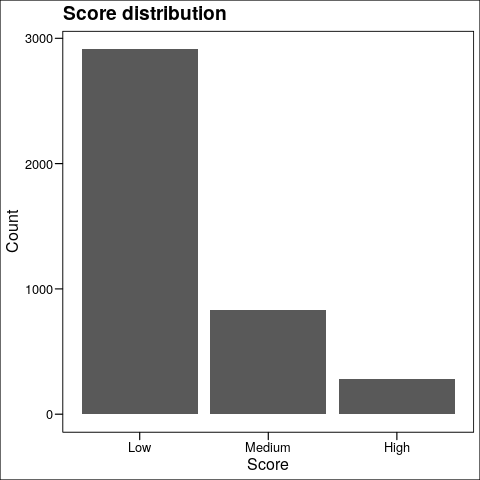

In [8]:
%%R

# Set theme 
theme_set(theme_base())

df %>%
  group_by(score) %>%
  count() %>%
  ggplot(aes(x = score, y = n)) +
    geom_col() +
    labs(x = "Score",
         y = "Count",
         title = "Score distribution")


- Score distribution by race


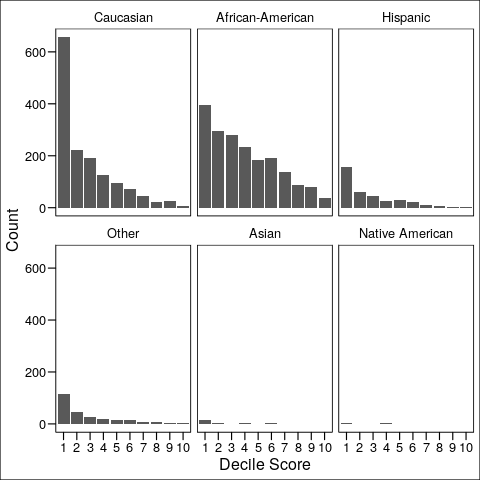

In [9]:
%%R

df %>%
  ggplot(aes(ordered(v_decile_score))) + 
          geom_bar() +
          facet_wrap(~race, nrow = 2) +
          labs(x = "Decile Score",
               y = "Count",
               Title = "Defendant's Decile Score")

## Modeling 

After filtering out bad rows, our first question is whether there is a significant difference in COMPAS scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [10]:
%%R

model_data <- function(data){

# Logistic regression model
lr_model <- glm(score ~ gender + age_cat + race + priors_count + crime + two_year_recid, 
             family = "binomial", data = data)

# OLS
ols_model1 <- lm(score_num ~ gender + age_cat + race + priors_count + crime + two_year_recid, 
             data = data)

ols_model2 <- lm(v_decile_score ~ gender + age_cat + race + priors_count + crime + two_year_recid, 
             data = data)

# Extract model outcomes with confidence intervals 
lr_est <- lr_model %>% 
    tidy(conf.int = TRUE) 

ols_est1 <- ols_model1 %>%
    tidy(conf.int = TRUE) 

ols_est2 <- ols_model2 %>%
    tidy(conf.int = TRUE) 

# AIC scores 
lr_AIC <- AIC(lr_model)
ols_AIC1 <- AIC(ols_model1)
ols_AIC2 <- AIC(ols_model2)
    
list(lr_est, ols_est1, ols_est2, lr_AIC, ols_AIC1, ols_AIC2)
}
    

## Model comparisons 

In [11]:
%%R

cat(paste0("AIC score of logistic regression:", model_data(df)[4], "\n",
           "AIC score of OLS regression (with categorical DV):", model_data(df)[5], "\n",
           "AIC score of OLS regression (with continuous DV):", model_data(df)[6]))

AIC score of logistic regression:3022.77943765996
AIC score of OLS regression (with categorical DV):5414.49127581608
AIC score of OLS regression (with continuous DV):15458.3861723106

### Logistic regression model

In [12]:
%%R

lr_model <- model_data(df)[1] %>% data.frame()

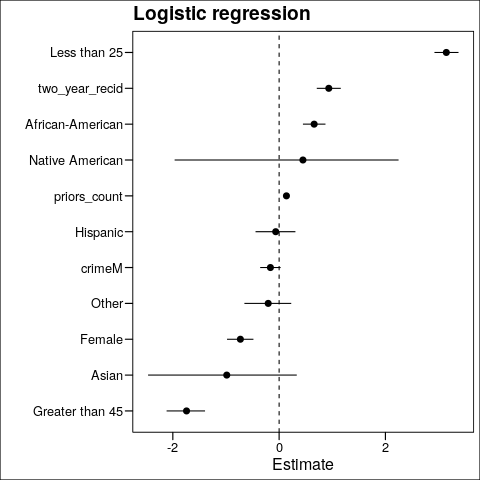

In [13]:
%%R

lr_model %>%
  data.frame() %>%
  filter(term != "(Intercept)") %>%
  mutate(term = gsub("race|age_cat|gender","", term)) %>%
  ggplot(aes(x = fct_reorder(term, estimate), y = estimate, ymax = conf.high, ymin = conf.low)) +
  geom_pointrange() +
  coord_flip() +
  labs(y = "Estimate", x = "",
      title = "Logistic regression") +
  geom_hline(yintercept = 0, linetype = "dashed")

In [14]:
%%R

interpret_estimate <- function(model){
    
    # Control 
    intercept <- model$estimate[model$term == "(Intercept)"]
    control <- exp(intercept) / (1 + exp(intercept))
    
    # Likelihood 
    model <- model %>% filter(term != "(Intercept)")
    
    model$likelihood <- (exp(model$estimate) / (1 - control + (control * exp(model$estimate))))
    
    return(model)
}

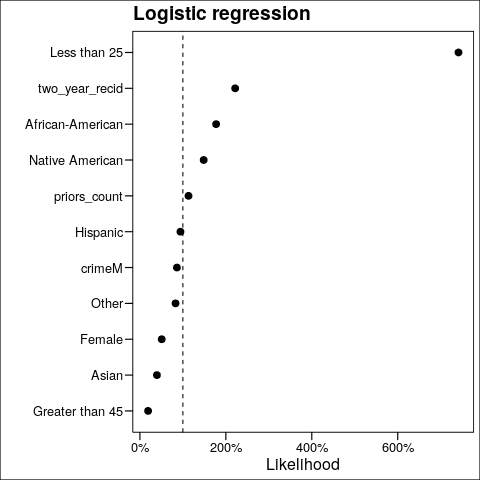

In [15]:
%%R

interpret_estimate(lr_model) %>%
    mutate(term = gsub("race|age_cat|gender","", term)) %>% 
    ggplot(aes(x = fct_reorder(term, likelihood), y = likelihood)) +
        geom_point(size = 3) +
        coord_flip() +
        labs(y = "Likelihood", x = "",
            title ="Logistic regression") +
        scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
        geom_hline(yintercept = 1, linetype = "dashed")